In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(palette="deep")

model_title = "Phi4-mini, chain-of-thought with fallback if unknown"

mmlu_entropy_df = pd.read_parquet("../../../data/out/cot_entropy/mmlu_phi4mini_w_fallback.parquet")

In [2]:
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,False,"[0.739037036895752, 1.6074764728546143, 0.2694...","[[{""token_idx"": 16, ""token_prob"": 0.0056026899...",350,To determine the most compelling criticism of ...,"{""min"": [-1.765625, -2.25, -1.0078125, -1.5546...","{""min"": [-2.0, -1.2890625, -0.97265625, -1.742...","{""min"": [0.08251953125, -0.859375, 0.36328125,..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.44923800230026245, 0.52848881483078, 0.0339...","[[{""token_idx"": 1, ""token_prob"": 1.20153881653...",298,To determine which of the given articles are n...,"{""min"": [-1.734375, -2.078125, -0.51953125, -1...","{""min"": [-1.9765625, -1.734375, -0.7421875, -1...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[0.7827358245849609, 1.3739895820617676, 0.138...","[[{""token_idx"": 12, ""token_prob"": 1.3965139260...",364,"To determine the correct answer, let's analyze...","{""min"": [-1.7734375, -2.375, -0.314453125, -1....","{""min"": [-1.7734375, -1.6953125, -0.306640625,...","{""min"": [0.130859375, -0.953125, 0.306640625, ..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.5698917508125305, 1.2224339246749878, 0.058...","[[{""token_idx"": 16, ""token_prob"": 0.0010091802...",345,"To find the total cost of the rental, we need ...","{""min"": [-1.828125, -2.140625, -0.376953125, -...","{""min"": [-1.890625, -1.7265625, -0.72265625, -...","{""min"": [-0.0869140625, -1.0, 0.60546875, 0.87..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.7429015040397644, 1.2687288522720337, 0.218...","[[{""token_idx"": 16, ""token_prob"": 0.0020184428...",278,"To solve this problem, we need to follow these...","{""min"": [-1.8203125, -2.1875, -0.58984375, -0....","{""min"": [-2.0, -2.28125, -1.1328125, -2.0625, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1...."


In [3]:
mmlu_entropy_df.value_counts("phi3_ans_token_index", dropna=False)

phi3_ans_token_index
-1       669
 419      49
 370      48
 415      43
 378      42
        ... 
 919       1
 915       1
 913       1
 677       1
 1021      1
Name: count, Length: 896, dtype: int64

In [4]:
# Filter out unanswered questions (phi3_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["phi3_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 11363 after filtering


In [5]:
from transformers import AutoTokenizer

from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "microsoft/Phi-4-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["phi3_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "phi3_every_token_info", "phi3_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["phi3_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_52426/782370464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer"] = mmlu_entropy_df_filtered.apply(
/var/folders/62/r46p4vgs7m5bbync7hl0ykjc0000gp/T/ipykernel_52426/782370464.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy"] = mmlu_entropy_df_filtered.apply(


In [6]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
from reasoning_fine_tune.prompts.mmlu_single_token_answer import option_ids_w_fallback
from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(
    mmlu_entropy_df_filtered, "phi3_answer", option_ids=option_ids_w_fallback
)

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "phi3_answer")

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

phi3_answer
1         1402
0         1371
2         1232
4         1211
3         1200
6          914
7          913
5          885
8          854
9          715
10         633
12           4
11           3
16           2
432          1
420          1
428          1
52           1
438          1
491          1
40           1
78           1
608          1
-            1
36           1
34           1
280          1
27           1
256          1
25           1
20           1
18           1
17           1
164          1
160          1
15           1
13           1
number       1
Name: count, dtype: int64
phi3_answer
1     1402
0     1371
2     1232
4     1211
3     1200
6      914
7      913
5      885
8      854
9      715
10     633
12       4
11       3
16       2
17       1
20       1
15       1
13       1
18       1
Name: count, dtype: int64
phi3_answer
1     1402
2     1232
4     1211
3     1200
6      914
7      913
5      885
8      854
9      715
10     633
12       4
11       3
1

In [7]:
print(mmlu_entropy_df_filtered.value_counts("phi3_answer_entropy", dropna=False))

phi3_answer_entropy
0.673946    2
0.549581    2
0.446998    2
0.041243    2
0.003144    2
           ..
0.027618    1
0.027624    1
0.027689    1
0.027703    1
2.762981    1
Name: count, Length: 9834, dtype: int64


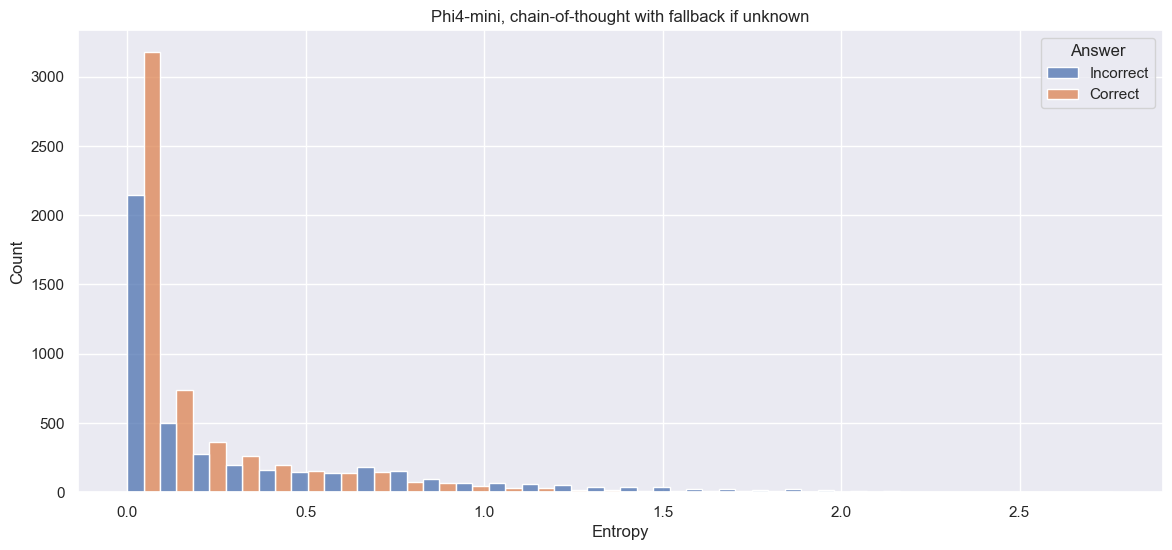

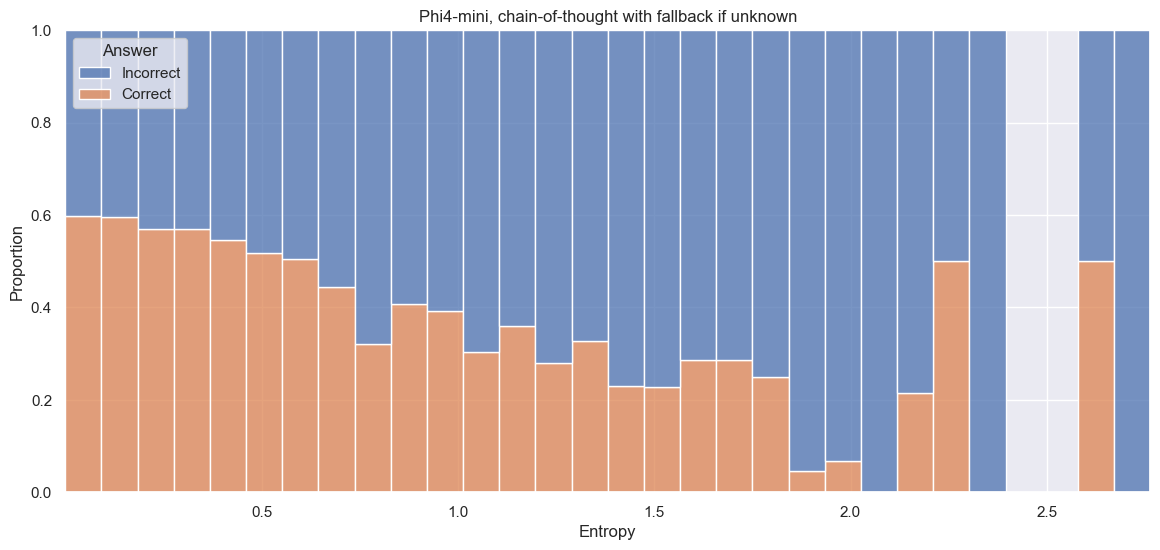

In [8]:
from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy",
    "phi3_ans_correct",
    model_name=model_title,
)

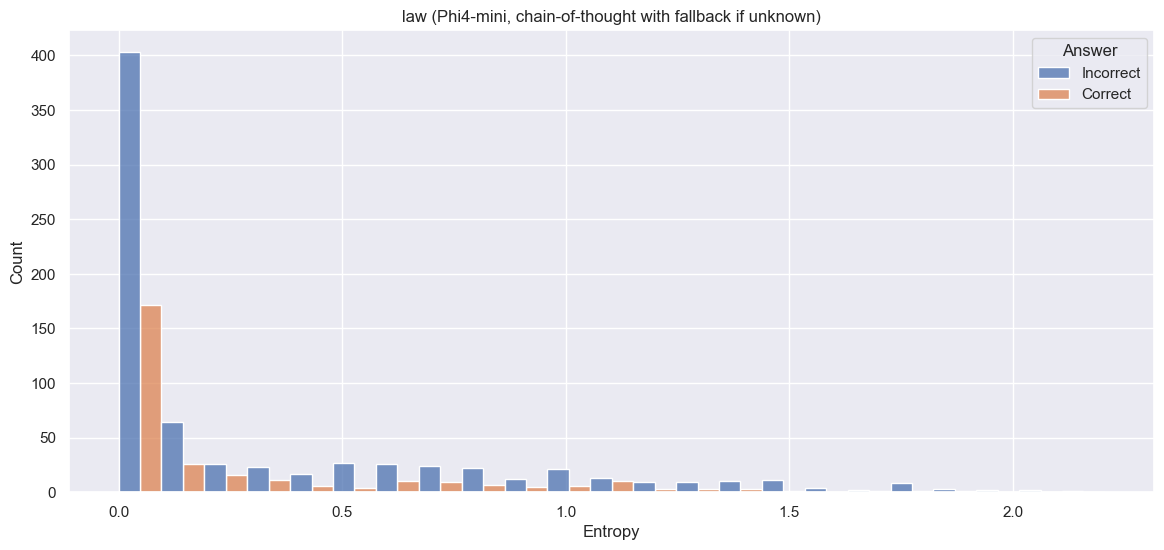

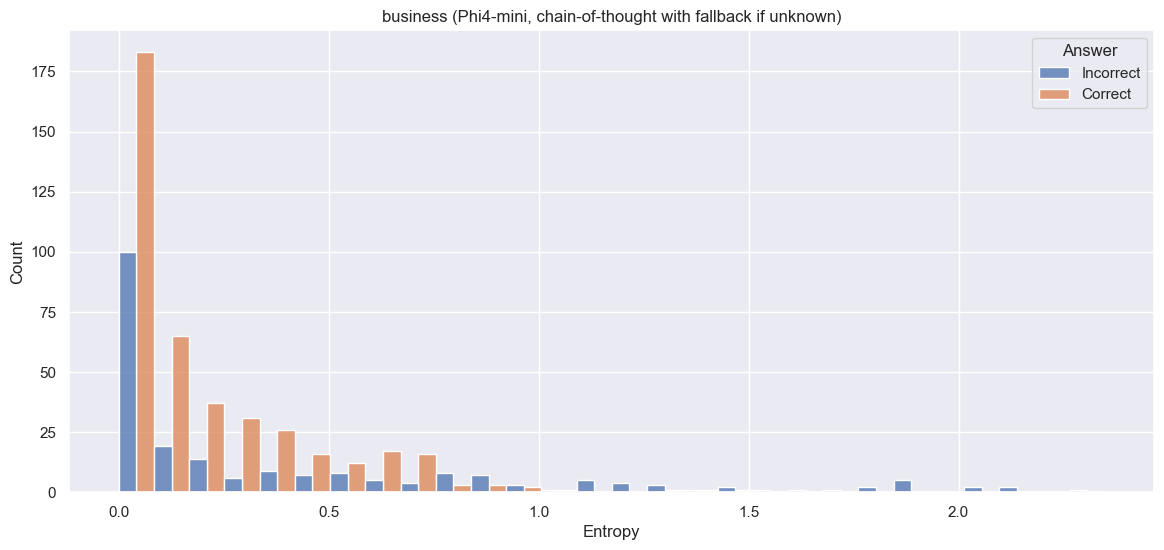

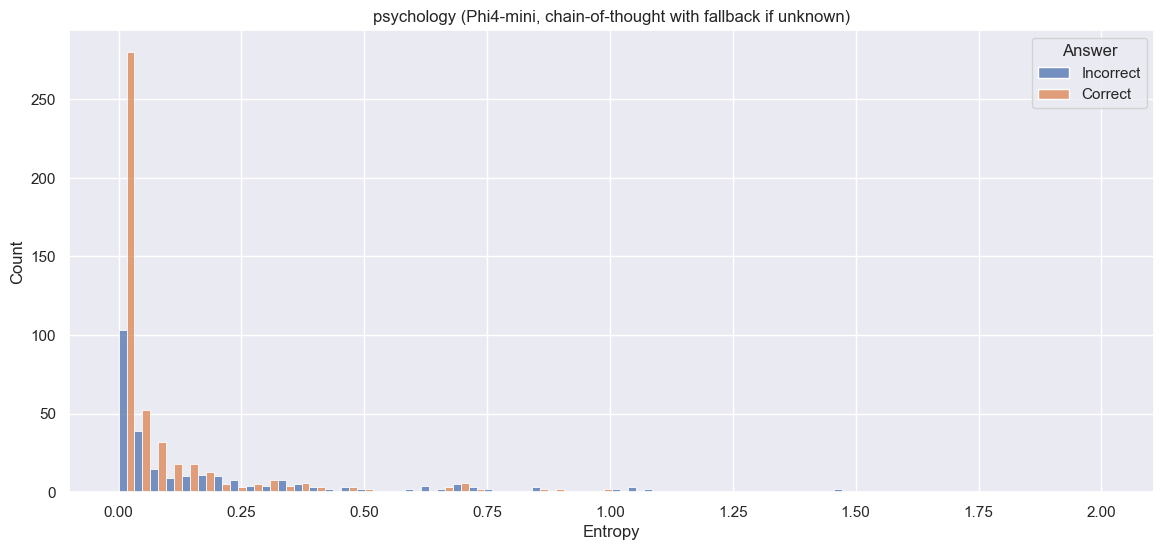

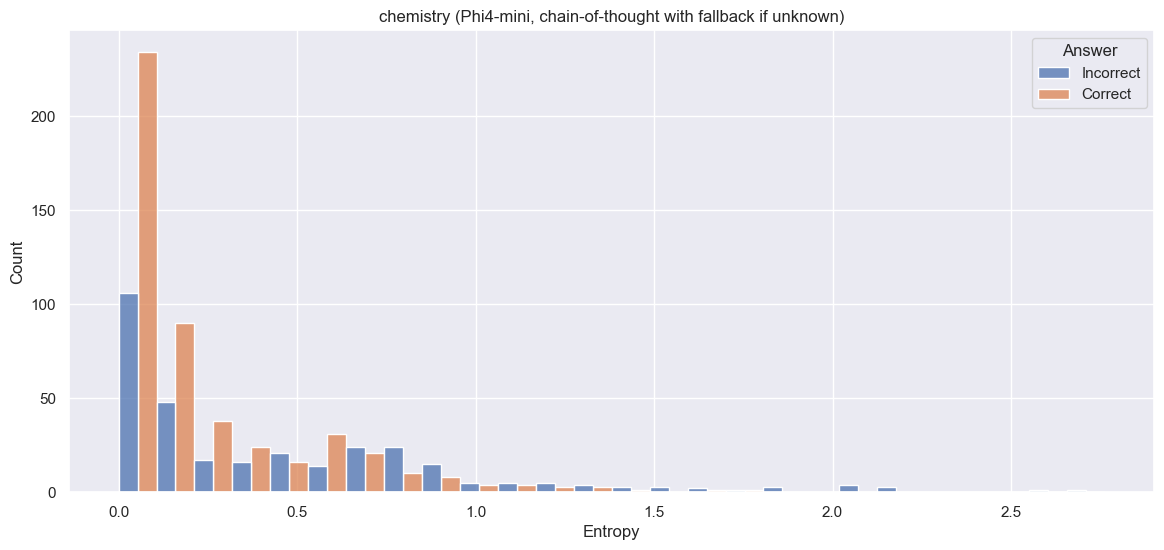

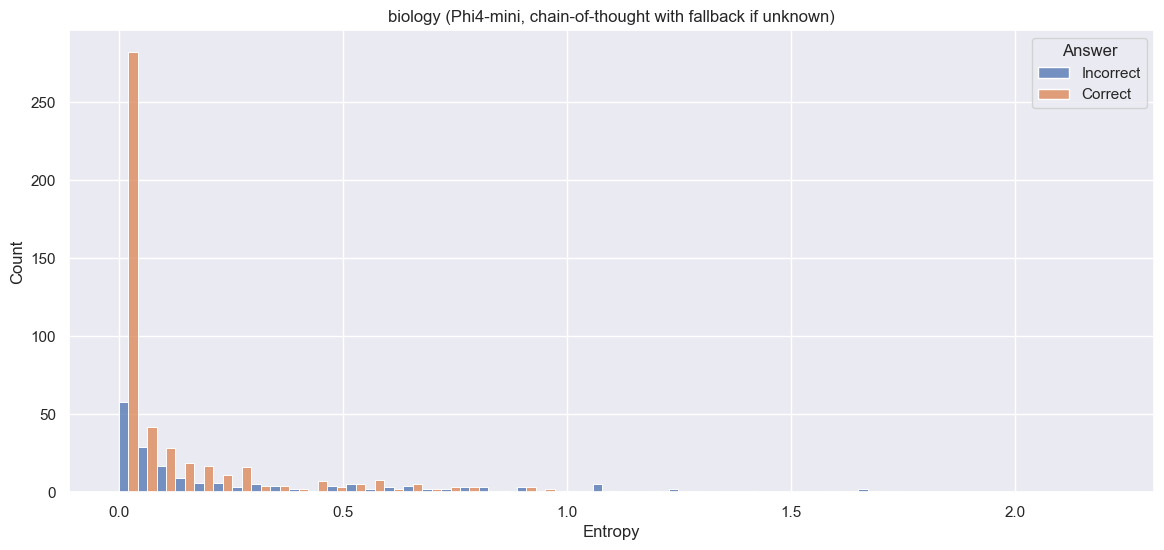

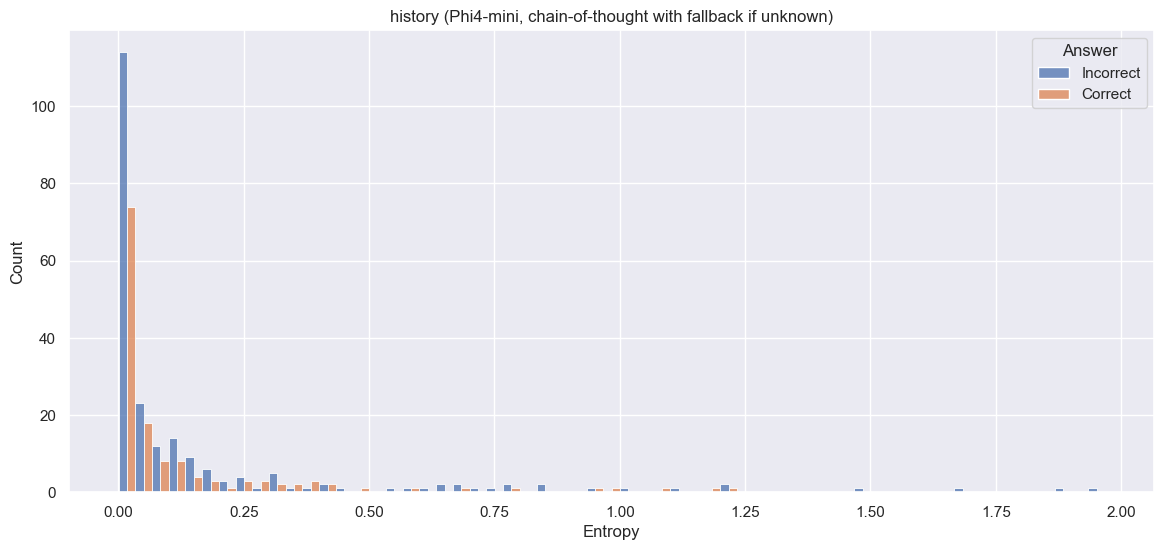

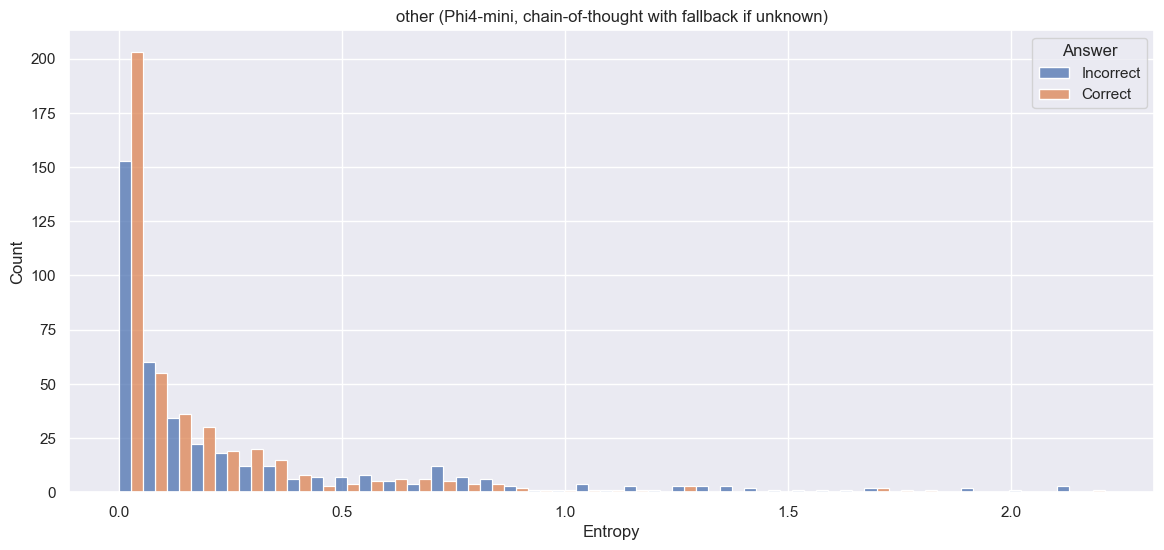

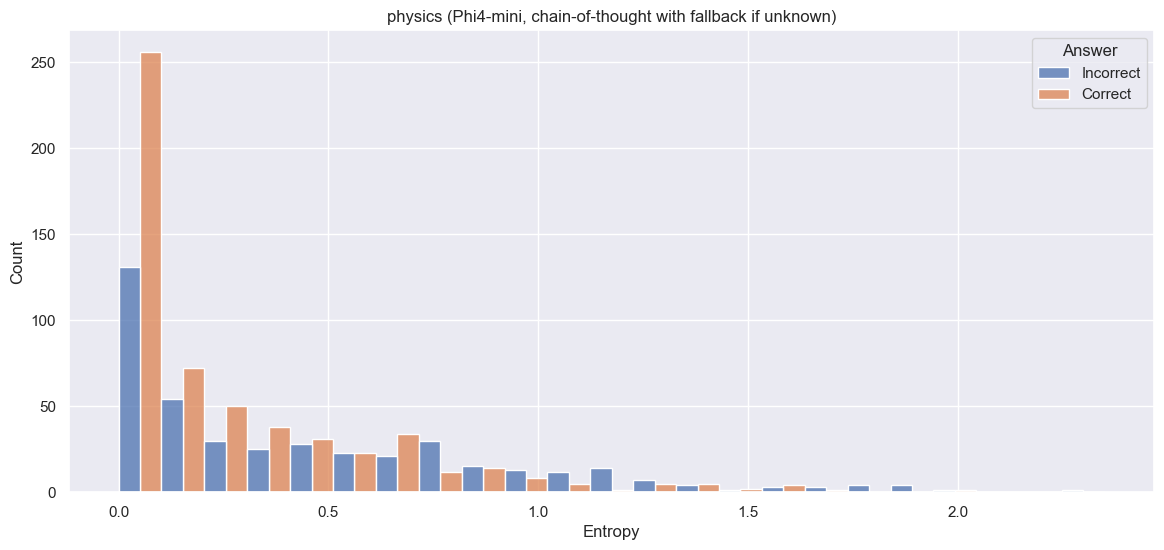

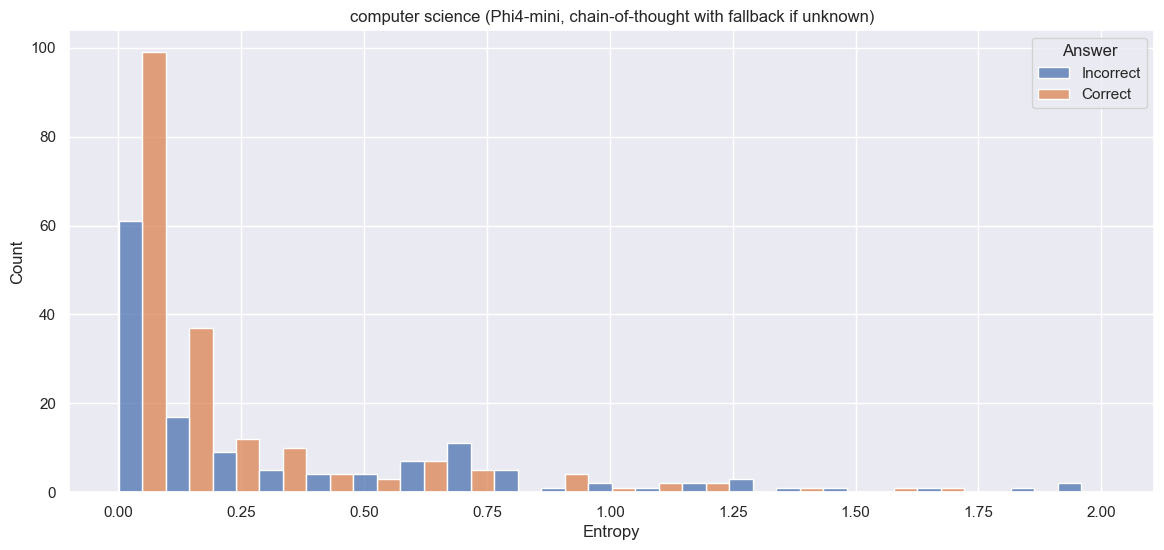

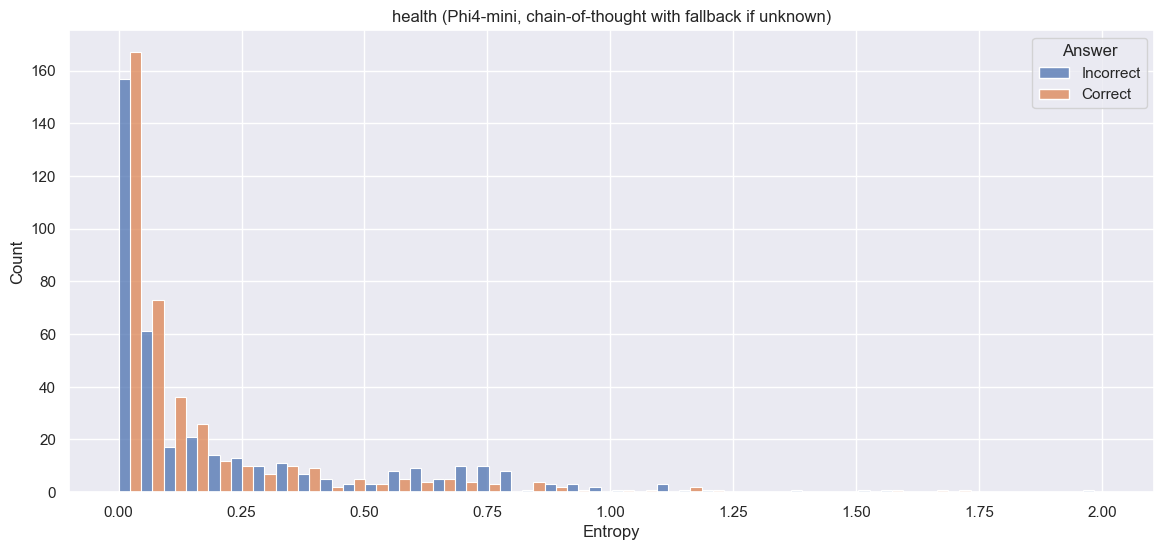

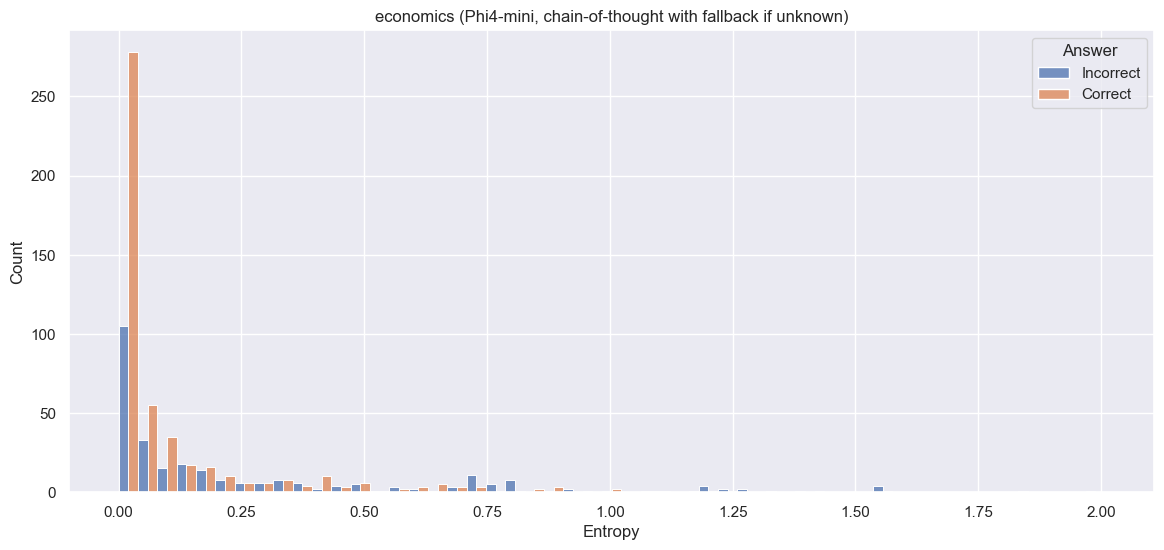

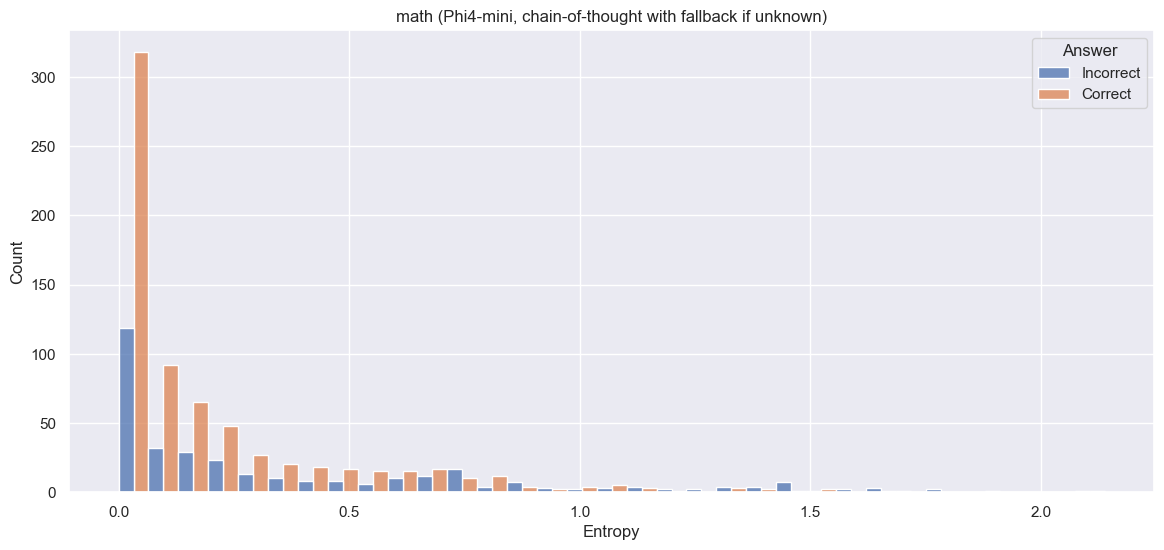

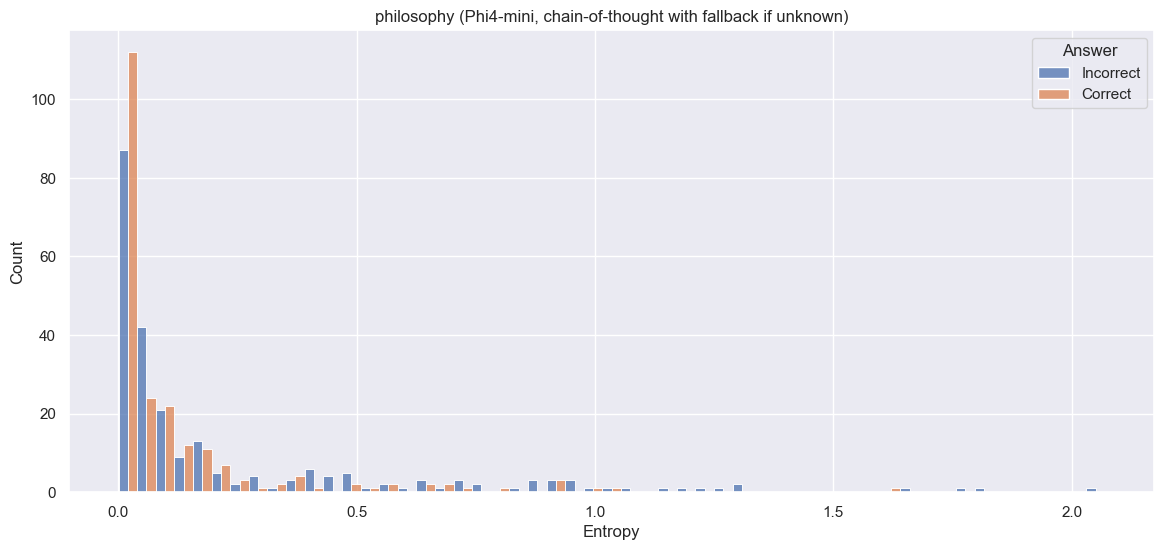

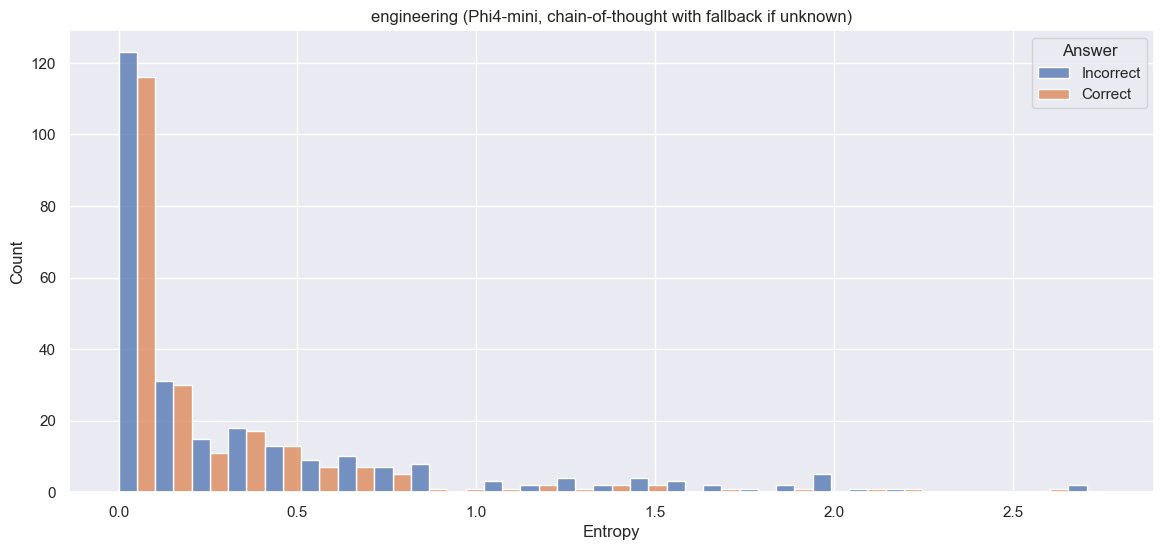

In [9]:
from reasoning_fine_tune.analysis.visualize_entropy_by_category import visualize_entropy_by_category

visualize_entropy_by_category(
    mmlu_entropy_df_filtered,
    "category",
    "phi3_answer_entropy",
    "phi3_ans_correct",
    model_name=model_title,
)

In [10]:
from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy",
    model_name=model_title,
)
roc_auc_res

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.583563,0.167127,9973,0.551990,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
1,law,0.523658,0.047315,1033,0.284608,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
2,business,0.559581,0.119163,636,0.652516,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
3,psychology,0.645464,0.290927,764,0.630890,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
4,chemistry,0.631474,0.262948,814,0.600737,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
5,biology,0.666118,0.332235,663,0.713424,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
6,history,0.512877,0.025754,358,0.391061,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
7,other,0.583656,0.167313,848,0.516509,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
8,physics,0.608188,0.216377,986,0.569980,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
9,computer science,0.584234,0.168469,327,0.577982,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy


In [11]:
from reasoning_fine_tune.analysis.join_with_masj_education_levels import join_with_masj_education_levels

mmlu_entropy_df_with_masj = join_with_masj_education_levels(mmlu_entropy_df_filtered)

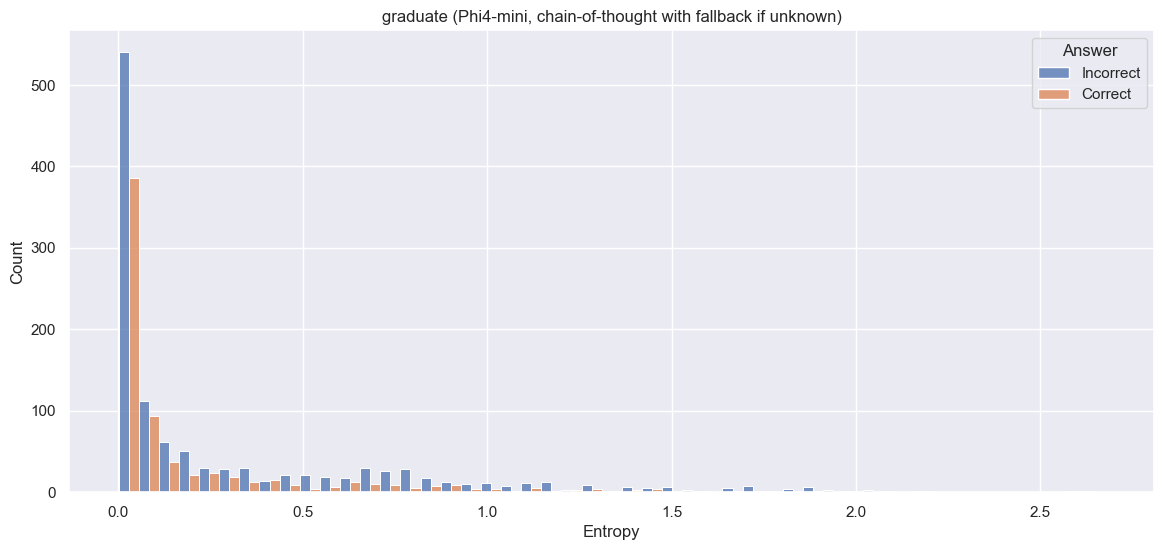

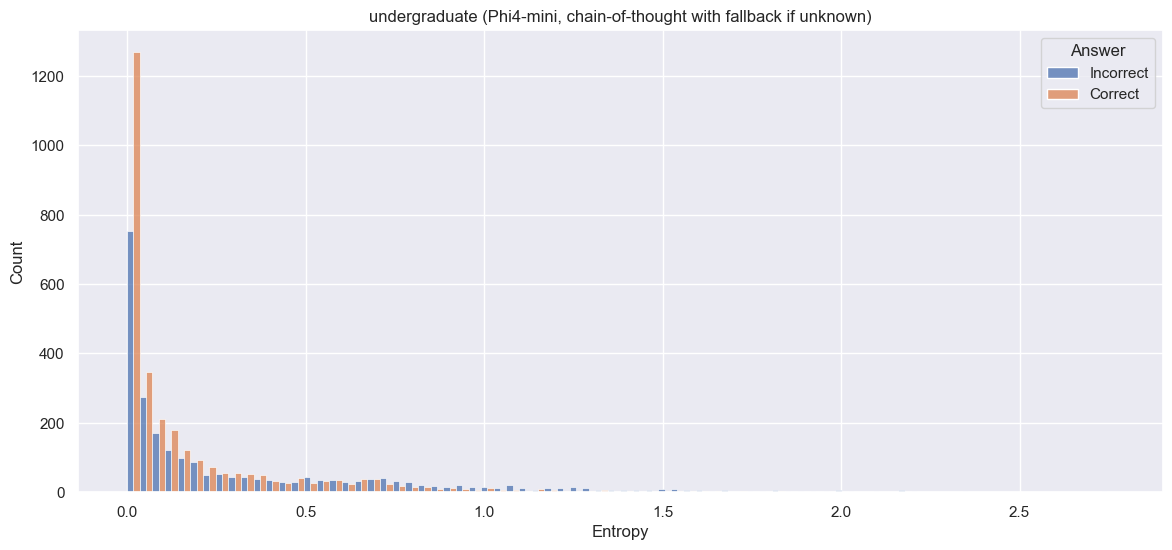

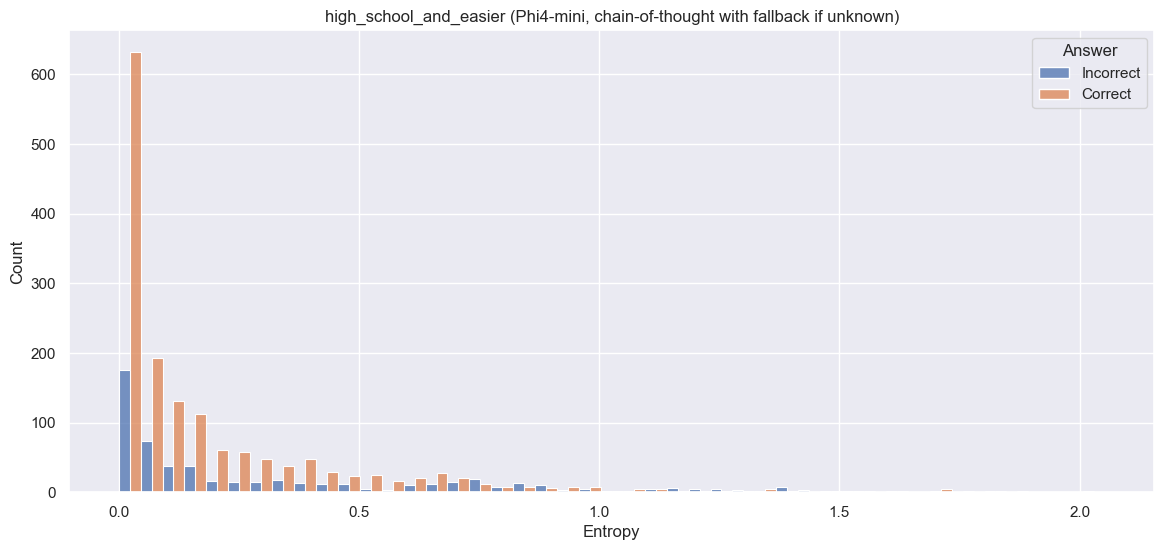

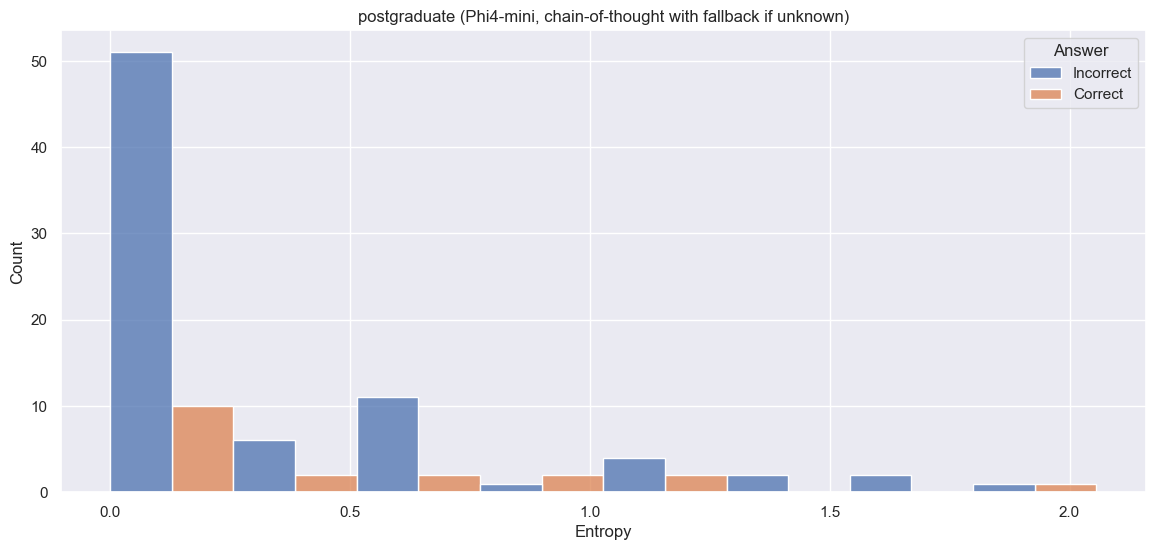

In [12]:
from reasoning_fine_tune.analysis.visualize_entropy_by_category import visualize_entropy_by_category

visualize_entropy_by_category(
    mmlu_entropy_df_with_masj,
    "masj_complexity",
    "phi3_answer_entropy",
    "phi3_ans_correct",
    model_name=model_title,
)

In [13]:
from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_with_masj,
    category_col="masj_complexity",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy",
    model_name=model_title,
)
roc_auc_res

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.583690,0.167379,9585,0.551487,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
1,graduate,0.572810,0.145620,1902,0.376972,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
2,undergraduate,0.600400,0.200800,5448,0.548091,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
3,high_school_and_easier,0.597004,0.194008,2138,0.731525,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
4,postgraduate,0.410931,0.178138,97,0.195876,"Phi4-mini, chain-of-thought with fallback if u...",phi3_answer_entropy
